In [1]:
import sys
sys.path.append('./..')


import logging
import dynaphos
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
import time
import pickle 

from dynaphos import utils
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map, get_visual_field_coordinates_probabilistically
from dynaphos.image_processing import canny_processor, sobel_processor
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.utils import get_data_kwargs, to_numpy

/scratch/jaap/miniconda3/envs/rl-mobility/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.basicConfig(level=logging.INFO)

# read parameters from yaml file
params = utils.load_params('../config/params.yaml')
params['run']['gpu'] = 1
params['thresholding']['use_threshold'] = False
params['run']['dropout_rate'] = 0.

device = get_data_kwargs(params)['device']

params['run']['resolution'] = [374,374]
# params['run']['fps'] = 35
# initialise simulator

with open('../config/DefaultCoordinateMap_1000_phosphenes.pickle', 'rb') as handle:
    coordinates_visual_field = pickle.load(handle,)
simulator = PhospheneSimulator(params, coordinates_visual_field)
data_kwargs = get_data_kwargs(params)
device = data_kwargs['device']

print(f'Number of phosphenes: {simulator.num_phosphenes}')

Number of phosphenes: 1000


## Preprocess a video

In [3]:
cap = cv2.VideoCapture("data/foreground_contours.mp4")

ret, frame = cap.read()

video = []
while ret:
    video.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
    ret, frame = cap.read()
    
orig_fps = cap.get(cv2.CAP_PROP_FPS)
duration = len(video) / orig_fps

cap.release()

video = torch.from_numpy(np.stack(video)).to(device)

# Interpolate frames
video = torch.nn.functional.interpolate(video.permute(1,2,0).unsqueeze(0),
                                size=(1242,1540)).permute(-1,0,1,2).squeeze()
n_frames = video.shape[0]
new_fps = n_frames/duration

print(f"fps: {new_fps} ({n_frames} frames)")

fps: 200.0 (1540 frames)


In [4]:
def get_sampling_mask(pMap):
    """Mask for creating stimulation vector by sampling an input image
    at the location (center) of each phosphene."""
    flatidx = torch.arange(pMap.shape[0],device=device) * pMap.shape[-2] * pMap.shape[-1]
    centers = pMap.flatten(start_dim=1).argmin(dim=-1) 
    sampling_mask = torch.zeros_like(pMap)
    sampling_mask.flatten()[centers + flatidx] = 1
    return sampling_mask, centers

def get_stimulation_sequence(simulator, video):
    resolution = simulator.phosphene_maps.shape[-2:]
    sampling_mask, centers = get_sampling_mask(simulator.phosphene_maps)
    stimulation_sequence = []
    for frame in video:
        resized = torch.nn.functional.interpolate(frame.view(1,1,*frame.shape), size=resolution).squeeze()
        stimulation_sequence.append(resized.flatten()[centers] * 128e-6)
    return stimulation_sequence

def get_simulator(params, n_phosphenes):
    coordinates_visual_field = get_visual_field_coordinates_probabilistically(params,n_phosphenes=n_phosphenes)
    r, phi = coordinates_visual_field.polar
    simulator = PhospheneSimulator(params, coordinates_visual_field)
    return simulator

### Save example video

In [61]:
stimulation_sequence = get_stimulation_sequence(simulator, (video[:,:,434:-434]*1.75 / 255).clamp(0,1))

phs = [] 
simulator.reset()
for stim in stimulation_sequence:
    phs.append(simulator(stim).detach().cpu().numpy())

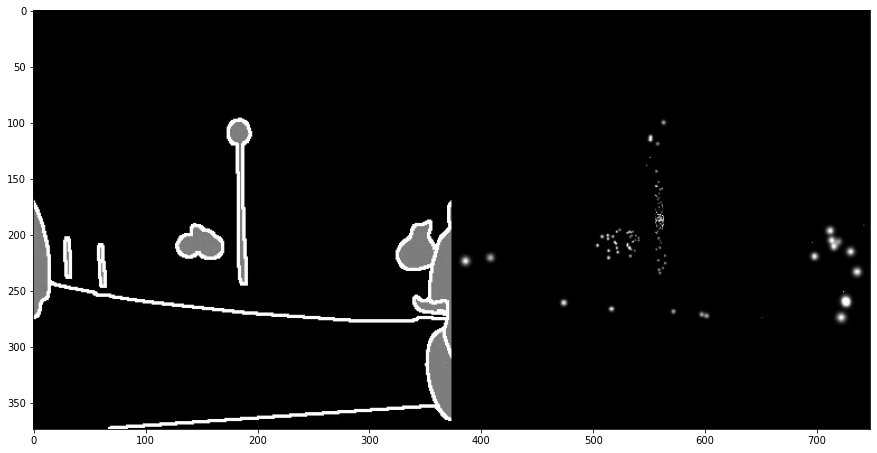

In [62]:
vid = np.concatenate([video[:, :, 434:-434].cpu().numpy(),
                     np.stack(phs)*255,],axis=-1).astype('uint8')

vid = np.stack([vid,vid,vid],axis=-1)

plt.figure(figsize=(15,15),cmap='gray')
plt.imshow(vid[10])

In [63]:
w, h, c= vid[0].shape
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
writer = cv2.VideoWriter('test.mp4', fourcc, 200, (h, w))

for frame in vid:
    writer.write(frame)
writer.release() 

## Time the performance

### get list of run conditions 

In [87]:
def get_spec_list(default_specs,
                  resolutions = ([1024,1024], [512,512], [256,256], [128,128], [64,64]),
                  phosphene_counts  = (10000, 5000, 1000, 500, 100, 50, 10),
                  num_repetitions = 5):
    spec_list = pd.DataFrame()
    for resolution in resolutions:
        for n_phosphenes in phosphene_counts:
            specs = defaults.copy()
            specs.update({'repetition': np.arange(num_repetitions),
                          'n_phosphenes': [n_phosphenes,]*num_repetitions,
                          'resolution': [resolution,]*num_repetitions, 
                          'res-tag': ['{}x{}'.format(*resolution),]*num_repetitions })
            new_row = pd.DataFrame(specs)
            spec_list = pd.concat([spec_list,new_row], ignore_index=True)
    return spec_list


DESCRIPTION = 'no_grad'


defaults = {'description': DESCRIPTION,
            'num_frames': n_frames,
            'simulation_fps': params['run']['fps']}

spec_list = get_spec_list(defaults)[::-1].reset_index(drop=True)
spec_list

,description,num_frames,simulation_fps,repetition,n_phosphenes,resolution,res-tag
0,no_grad,1540,35,4,10,"[64, 64]",64x64
1,no_grad,1540,35,3,10,"[64, 64]",64x64
2,no_grad,1540,35,2,10,"[64, 64]",64x64
3,no_grad,1540,35,1,10,"[64, 64]",64x64
4,no_grad,1540,35,0,10,"[64, 64]",64x64
...,...,...,...,...,...,...,...
170,no_grad,1540,35,4,10000,"[1024, 1024]",1024x1024
171,no_grad,1540,35,3,10000,"[1024, 1024]",1024x1024
172,no_grad,1540,35,2,10000,"[1024, 1024]",1024x1024
173,no_grad,1540,35,1,10000,"[1024, 1024]",1024x1024


In [88]:
results = spec_list.copy()

for i, row in spec_list.iterrows():
    
    
    # Adjust params
    resolution = row.resolution
    n_phosphenes = row.n_phosphenes    
    params['run']['resolution'] = resolution
#     params['run']['fps'] = 35
    
    try:
        # Get simulator and stimulation sequence
        simulator = get_simulator(params, n_phosphenes)
        stimulation_sequence = get_stimulation_sequence(simulator, video)
    except:
        print("could not initialize simulator")
        continue

    tic = time.perf_counter()
    for stim in stimulation_sequence:
        with torch.no_grad():
            simulator(stim)
    toc = time.perf_counter()
    
    # Calculate fps and append to results
    duration = toc-tic
    fps = row.num_frames / duration
    results.loc[i, 'duration'] = duration
    results.loc[i, 'fps'] = fps
    
    print(results.loc[i, ['resolution', 'n_phosphenes', 'duration', 'fps']].to_dict())
    

{'resolution': [64, 64], 'n_phosphenes': 10, 'duration': 0.593277117004618, 'fps': 2595.7515566675947}
{'resolution': [64, 64], 'n_phosphenes': 10, 'duration': 0.5962963069905527, 'fps': 2582.6086493344637}
{'resolution': [64, 64], 'n_phosphenes': 10, 'duration': 0.590161204978358, 'fps': 2609.4565129140838}
{'resolution': [64, 64], 'n_phosphenes': 10, 'duration': 0.5875578069826588, 'fps': 2621.0187009657957}
{'resolution': [64, 64], 'n_phosphenes': 10, 'duration': 0.6306951320148073, 'fps': 2441.750255912621}
{'resolution': [64, 64], 'n_phosphenes': 50, 'duration': 0.6279674699762836, 'fps': 2452.3563299515517}
{'resolution': [64, 64], 'n_phosphenes': 50, 'duration': 0.6269874940044247, 'fps': 2456.1893414561987}
{'resolution': [64, 64], 'n_phosphenes': 50, 'duration': 0.6331750320387073, 'fps': 2432.186871048094}
{'resolution': [64, 64], 'n_phosphenes': 50, 'duration': 0.6048776670359075, 'fps': 2545.9693487221784}
{'resolution': [64, 64], 'n_phosphenes': 50, 'duration': 0.618133580

{'resolution': [256, 256], 'n_phosphenes': 50, 'duration': 0.7497242519748397, 'fps': 2054.0885478140854}
{'resolution': [256, 256], 'n_phosphenes': 50, 'duration': 0.7672900370089337, 'fps': 2007.0637252156441}
{'resolution': [256, 256], 'n_phosphenes': 100, 'duration': 1.3473002999671735, 'fps': 1143.0265398423214}
{'resolution': [256, 256], 'n_phosphenes': 100, 'duration': 1.3523076010169461, 'fps': 1138.7941610635833}
{'resolution': [256, 256], 'n_phosphenes': 100, 'duration': 1.3510019829845987, 'fps': 1139.8946999306927}
{'resolution': [256, 256], 'n_phosphenes': 100, 'duration': 1.3511041929596104, 'fps': 1139.8084677885656}
{'resolution': [256, 256], 'n_phosphenes': 100, 'duration': 1.3515629449975677, 'fps': 1139.4215901670577}
{'resolution': [256, 256], 'n_phosphenes': 500, 'duration': 6.27681588602718, 'fps': 245.3473270465355}
{'resolution': [256, 256], 'n_phosphenes': 500, 'duration': 6.247044146992266, 'fps': 246.51658668707444}
{'resolution': [256, 256], 'n_phosphenes': 

KeyboardInterrupt: 

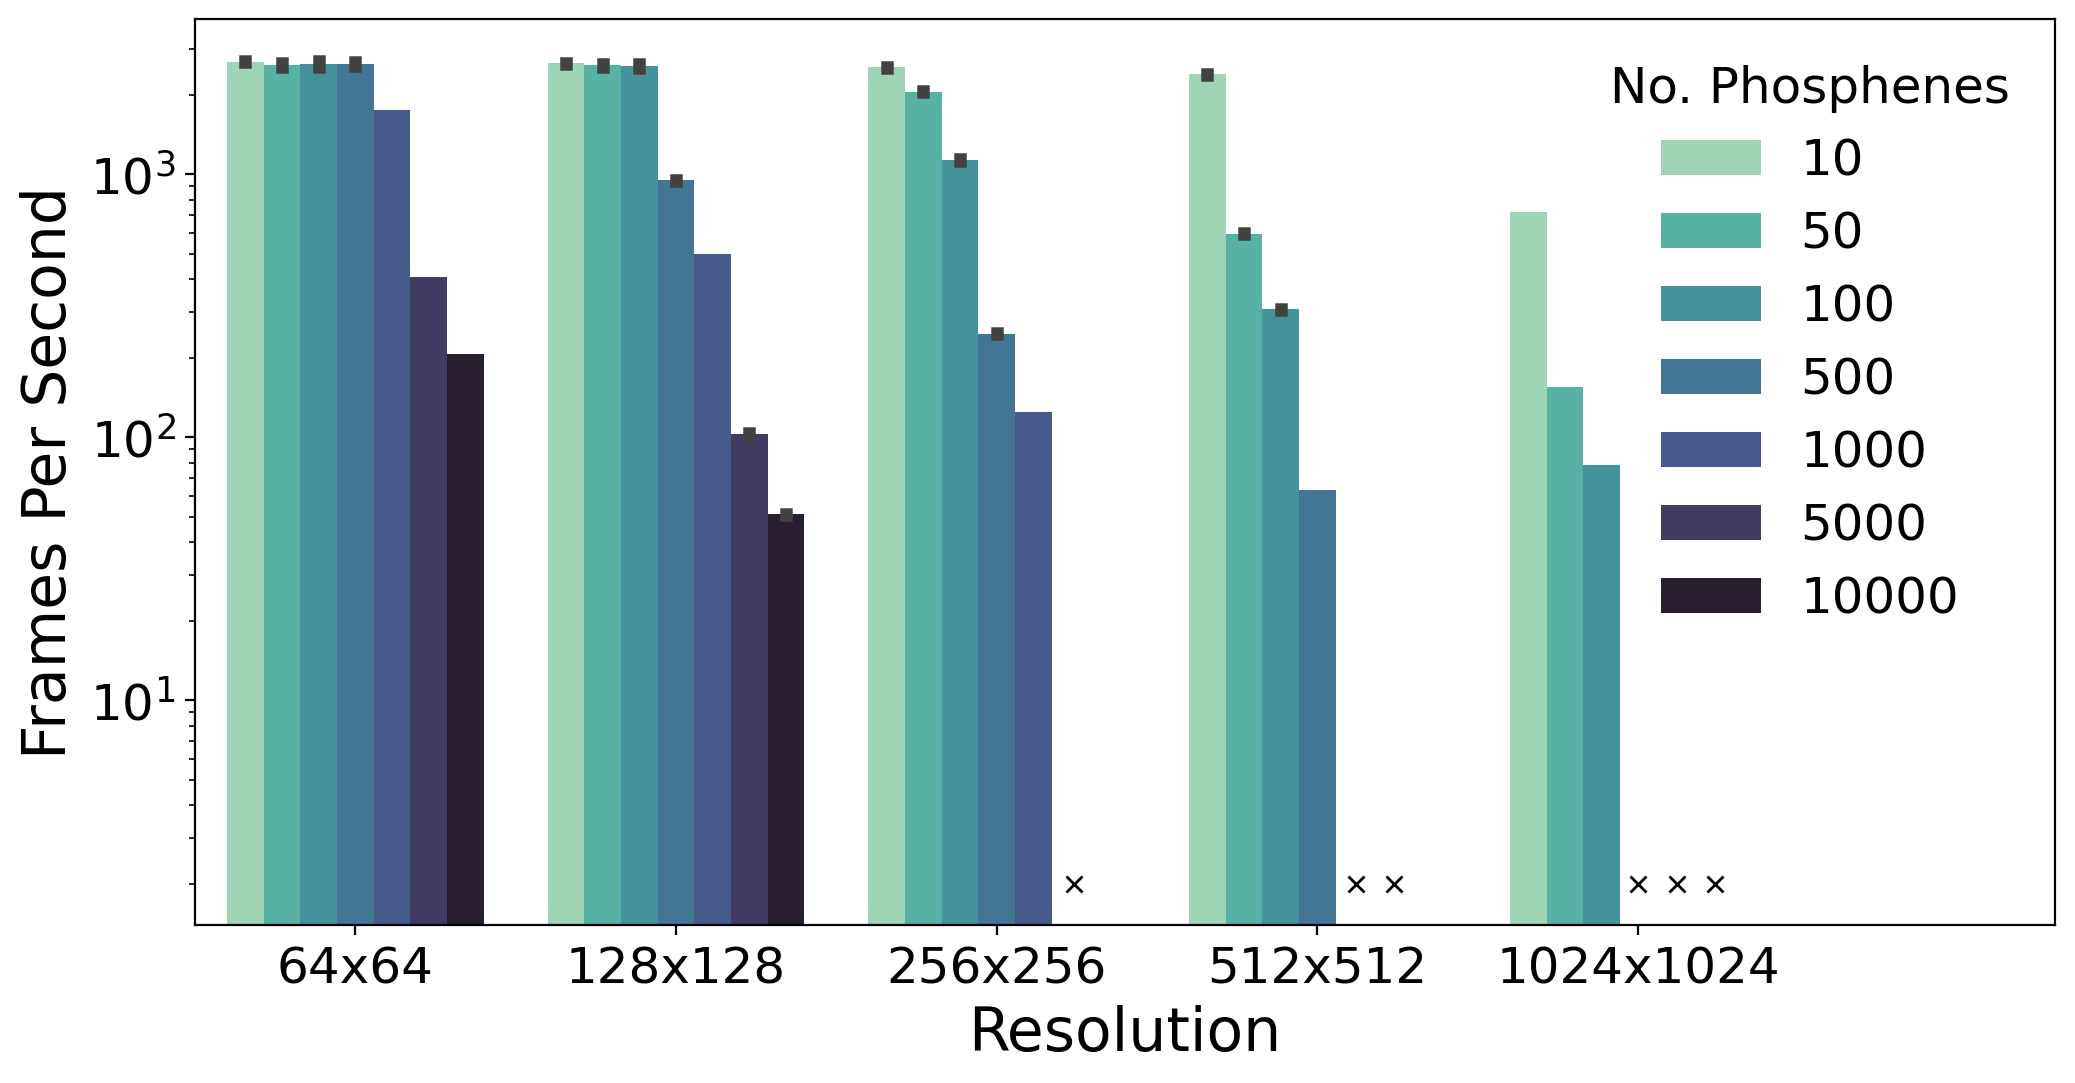

In [22]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    'axes.labelsize': 'large',
    'font.size': 18,
    'lines.linewidth': 2.5})

previous_results = pd.read_csv('results/performance_default.csv',)
f, ax = plt.subplots(figsize=(12, 6),dpi=200)

# sns.barplot(data= results, x='n_phosphenes', y='fps', hue='res-tag', ax=ax)
sns.barplot(data= previous_results, hue='n_phosphenes', y='fps', x='res-tag', ax=ax,
            palette=sns.color_palette("mako_r", 7))
ax.set(xlabel = 'Resolution',
       ylabel = 'Frames Per Second',
#        ylim = [None,50000000000],
       xlim = [None,5.3],
       yscale="log", 
        )

ax.legend(title='No. Phosphenes', ncol=1,
#           loc='lower left',
           loc='upper right',
#           bbox_to_anchor=(1, 1)
#           alpha = 0.1
          fancybox=True,
          framealpha=0.0
          
         )

empty = [2.24, 3.12, 3.24, 4., 4.12, 4.24 ] 
ax.plot(empty, np.ones_like(empty)*2, 'kx')

In [96]:
f.savefig("results/Performance_testing.png")

In [95]:
previous_results.fps.min()

50.8357099801367

In [39]:
results.resolution




In [9]:
list((10000, 5000, 1000, 500, 100, 50, 10))[::-1]

[10, 50, 100, 500, 1000, 5000, 10000]